<h2>Library</h2>

In [57]:
import requests
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

<h2>Main</h2>

In [44]:
# Load csv file from "Portugal Crimes Report"
df = pd.read_csv('csv/df_cities_crimes.csv')

In [43]:
# Get the Latitude and Longitude using Bing Maps API
# Define the cities to plot
cities = df['city'].unique()

# Create an empty list to store city information dictionaries
city_info_list = []

# Loop through the cities and add a marker for each one
for city in cities:
    # Use the Bing Maps REST Services API to get the latitude and longitude coordinates of the city
    url = 'http://dev.virtualearth.net/REST/v1/Locations'
    params = {'q': city, 'key': 'AqftqirjkuYeZgkG9LEdoTjhJq8d0RuX0oVV-gDt5q2w5hgqtnGcB6BfwJsp29pr'}
    response = requests.get(url, params=params).json()

    # Check if the response contains any results
    if 'resourceSets' in response and response['resourceSets']:
        location = response['resourceSets'][0]['resources'][0]['point']['coordinates']

        # Create a dictionary with city information
        city_info = {'city': city, 'latitude': location[0], 'longitude': location[1]}

        # Add the city information dictionary to the list
        city_info_list.append(city_info)

In [48]:
# Convert dictionary into a dataframe
df_map = pd.DataFrame(city_info_list)

df_map.head()

,city,latitude,longitude
0,Oliveira do Bairro,40.515446,-8.494024
1,Sever do Vouga,40.733063,-8.369164
2,Vagos,40.555264,-8.681458
3,Figueira da Foz,40.150784,-8.851213
4,Mealhada,40.378105,-8.451446


In [53]:
# Merge original dataframe with dataframe with coordinates
df_merged = pd.merge(df, df_map, on='city', how='left')

# Create a file with coordinates
df_merged.to_csv('csv/df_cities_crimes_map.csv')

df_merged.head()

,city,crime,value,latitude,longitude
0,Oliveira do Bairro,Roubo por esticão e na via pública,3,40.515446,-8.494024
1,Sever do Vouga,Roubo por esticão e na via pública,4,40.733063,-8.369164
2,Vagos,Roubo por esticão e na via pública,3,40.555264,-8.681458
3,Figueira da Foz,Roubo por esticão e na via pública,19,40.150784,-8.851213
4,Mealhada,Roubo por esticão e na via pública,0,40.378105,-8.451446


In [63]:
# get the 30 most dangerous cities in Portugal
df_most_dangerous_cities = df_merged.groupby(['city','latitude','longitude'])['value'].sum().sort_values(ascending=False).head(30).reset_index()

C:\Users\Rafael_Fagundes\AppData\Local\Temp\ipykernel_25952\3830979954.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


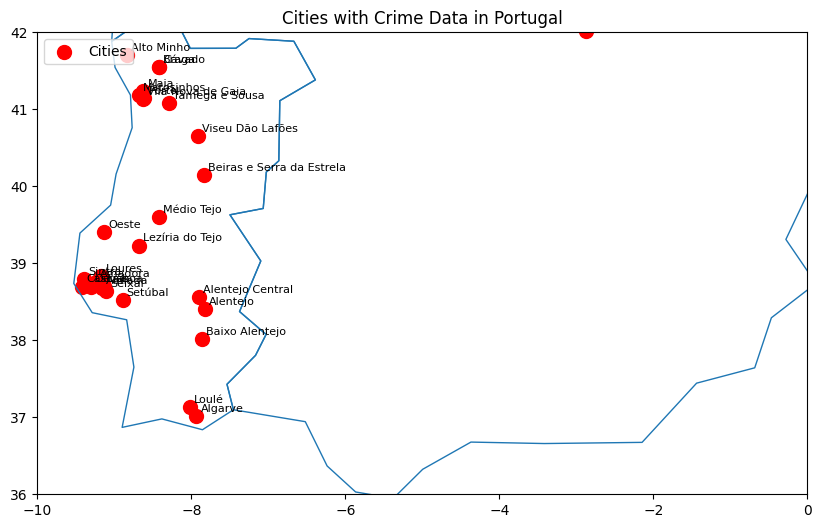

In [64]:
# Create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df_most_dangerous_cities['longitude'], df_most_dangerous_cities['latitude'])]
gdf = gpd.GeoDataFrame(df_most_dangerous_cities, geometry=geometry)

# Plot the cities using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.boundary.plot(figsize=(10, 6), linewidth=1)

# Define the bounding box for Portugal (longitude and latitude limits)
# Adjust these coordinates to match the desired area in Portugal
bbox = [-10, 36, 0, 42]  # [min_longitude, min_latitude, max_longitude, max_latitude]

# Set the axis limits to the bounding box
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

gdf.plot(ax=ax, color='red', markersize=100, marker='o', label='Cities')

# Add labels for the cities (optional)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['city']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', fontsize=8)

# Add titles and legend
plt.title('Cities with Crime Data in Portugal')
plt.legend(loc='upper left')

# Show the map
plt.show()


In [35]:
# Set up the map
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
        
# Save the map to an HTML file
map.save('html/cities_map.html')